<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_13/s13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Install packages

In [2]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull
!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull
!cd ../

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 1157 (delta 141), reused 299 (delta 121), pack-reused 821
Receiving objects: 100% (1157/1157), 184.47 MiB | 19.29 MiB/s, done.
Resolving deltas: 100% (586/586), done.
Updating files: 100% (123/123), done.
Already up to date.
Cloning into 'dl_hub'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 273 (delta 16), reused 0 (delta 0), pack-reused 248
Receiving objects: 100% (273/273), 60.65 KiB | 1.26 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Already up to date.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import sys
sys.path.append("ERA_V1/session_13")
sys.path.append("dl_hub")

In [4]:
!git -C dl_hub pull


Already up to date.


In [5]:
import dl_hub.models.YOLO_V3.config as config
import torch
import torch.optim as optim

from dl_hub.models.YOLO_V3.model import YOLOv3
from tqdm import tqdm
from dl_hub.models.YOLO_V3.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from dl_hub.models.YOLO_V3.loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [6]:
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, scheduler):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [11]:
torch.cuda.empty_cache()

In [13]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

train_loader, test_loader, train_eval_loader = get_loaders(
    train_csv_path=config.DATASET + "/100examples.csv", test_csv_path=config.DATASET + "/8examples.csv"
)

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-01


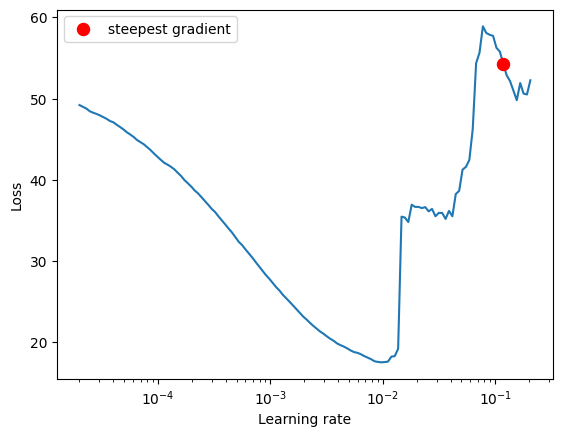

In [8]:
from torch_lr_finder import LRFinder
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)


from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = config.NUM_EPOCHS * 2 // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, scheduler)

    #if config.SAVE_MODEL:
    #   save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

    print(f"Currently epoch {epoch}")
    print("On Train Eval loader:")
    print("On Train loader:")
    check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)

    if epoch > 0 and epoch % 3 == 0:
        check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
        pred_boxes, true_boxes = get_evaluation_bboxes(
            test_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"MAP: {mapval.item()}")
        model.train()

Pytorch Lightning Definitions

In [ ]:
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torchmetrics.functional import accuracy


class LitYOLOv3(LightningModule):
    def __init__(self,
                 loss_criterion,
                 scaled_anchors,
                 optimizer=None,
                 scheduler_dict=None,
                 num_classes=10,
                 epochs=20):
        super().__init__()

        self.save_hyperparameters()
        self.model = YOLOv3(num_classes=num_classes)
        self.loss_criterion = loss_criterion
        self.scaled_anchors = scaled_anchors
        self.optimizer = None
        self.scheduler_dict = None
        self.epochs = epochs

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_scheduler_dict(self, scheduler_dict):
        self.scheduler_dict = scheduler_dict

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (y[0],y[1],y[2])

        out = self(x)
        loss = (
                self.loss_criterion(out[0], y0, self.scaled_anchors[0]) +
                self.loss_criterion(out[1], y1, self.scaled_anchors[1]) +
                self.loss_criterion(out[2], y2, self.scaled_anchors[2])
            )
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        """
        Evaluate the model on validation dataset.
        we compute the class accuracy, the no object accuracy, and the object accuracy
        """

        tot_class_preds, correct_class = 0, 0
        tot_noobj, correct_noobj = 0, 0
        tot_obj, correct_obj = 0, 0
        x, y = batch
        out = self(x)

        for i in range(3):
            obj = y[i][..., 0] == 1 # in paper this is Iobj_i
            noobj = y[i][..., 0] == 0  # in paper this is Iobj_i
            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

        if stage:
            class_acc = (correct_class/(tot_class_preds+1e-16))*100
            no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
            obj_acc = (correct_obj/(tot_obj+1e-16))*100
            self.log(f"Class accuracy is: {class_acc:2f}%", prog_bar=True)
            self.log(f"No obj accuracy is: {no_obj_acc:2f}%", prog_bar=True)
            self.log(f"Obj accuracy is: {obj_acc:2f}%", prog_bar=True)


    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_id):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler_dict}




In [ ]:
import torch
import numpy as np
from typing import List, Any
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning import LightningDataModule, seed_everything
from dl_hub.models.dataset_org import YOLODataset



class YOLODataModule(LightningDataModule):
    def __init__(self,
                 csv_files,
                 img_dir,
                 label_dir,
                 anchors,
                 image_size=416,
                 S=[13, 26, 52],
                 C=20,
                 train_transforms = None,
                 val_transforms = None,
                 test_transforms = None,
                 val_split=0.2,
                 num_workers = 1,
                 pin_memory = False):

        # Initialize the class. Set up the datadir, image dims, and num classes
        super().__init__()
        self.train_csv_path, self.test_csv_path = csv_files
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.anchors = anchors
        self.image_size = image_size
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.test_transforms = test_transforms
        self.val_split = val_split
        self.S = S
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def get_dataset_train(self):
        return YOLODataset( self.train_csv_path,
                transform = self.train_transforms,
                S=self.S,
                img_dir=self.img_dir,
                label_dir=self.label_dir,
                anchors=self.anchors)

    def get_dataset_test(self):
        return YOLODataset(
            self.test_csv_path,
            transform=self.test_transforms,
            S=self.S,
            img_dir=self.img_dir,
            label_dir=self.label_dir,
            anchors=self.anchors)

    def get_dataset_val(self):
        return YOLODataset(
            self.train_csv_path,
            transform=self.val_transforms,
            S=self.S,
            img_dir=self.img_dir,
            label_dir=self.label_dir,
            anchors=self.anchors)


    def _split_dataset(self, dataset: Dataset, train: bool = True) -> Dataset:
        """Splits the dataset into train and validation set."""
        len_dataset = len(dataset)
        splits = self._get_splits(len_dataset)
        dataset_train, dataset_val = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))
        if train:
            return dataset_train
        return dataset_val

    def _get_splits(self, len_dataset: int) -> List[int]:
        """Computes split lengths for train and validation set."""
        if isinstance(self.val_split, int):
            train_len = len_dataset - self.val_split
            splits = [train_len, self.val_split]
        elif isinstance(self.val_split, float):
            val_len = int(self.val_split * len_dataset)
            train_len = len_dataset - val_len
            splits = [train_len, val_len]
        else:
            raise ValueError(f"Unsupported type {type(self.val_split)}")

        return splits

    def prepare_data(self):
        # Download the dataset
        YOLODataset(self.data_dir, train=True, download=False)
        YOLODataset(self.data_dir, train=False, download=False)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == 'fit' or stage is None:
            dataset_train = self.get_dataset_train()
            dataset_val = self.get_dataset_val()

            # Split
            self.train_dataset = self._split_dataset(dataset_train)
            self.val_dataset = self._split_dataset(dataset_val, train=False)

        if stage == 'test' or stage:
            self.test_dataset = self.get_dataset_test()

    def train_dataloader(self):
        train_data_loader = DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=True,
            drop_last=False)
        return train_data_loader

    def val_dataloader(self):
        val_data_loader = DataLoader(
            dataset=self.train_eval_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            drop_last=False)
        return val_data_loader

    def test_dataloader(self):
        test_data_loader = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            drop_last=False)
        return test_data_loader